In [1]:
import torchvision
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import json
import utils as ut

In [2]:
# training set
train_data = torchvision.datasets.FashionMNIST('./data', train = True, download = True,
transform = torchvision.transforms.ToTensor())
# test set
test_data = torchvision.datasets.FashionMNIST('./data', train = False,
transform = torchvision.transforms.ToTensor())

In [3]:
# Determine the number of samples per class for the split
samples_per_class = 6000  
num_classes = 10 
val_samples_per_class = int(samples_per_class * 0.1)  # 10% for validation

# Prepare indices for splitting
indices = np.arange(len(train_data))
targets = np.array(train_data.targets)

train_indices = []
val_indices = []

for i in range(num_classes):
    class_indices = indices[targets == i]
    np.random.shuffle(class_indices)  # Shuffle indices to ensure random split
    val_indices.extend(class_indices[:val_samples_per_class])
    train_indices.extend(class_indices[val_samples_per_class:])

# Convert to PyTorch tensors
train_indices = torch.tensor(train_indices)
val_indices = torch.tensor(val_indices)

# Create subset datasets
train_subset = torch.utils.data.Subset(train_data, train_indices)
val_subset = torch.utils.data.Subset(train_data, val_indices)

# Create DataLoaders
train_generator = torch.utils.data.DataLoader(train_subset, batch_size=50, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_subset, batch_size=50, shuffle=False)
test_generator = torch.utils.data.DataLoader(test_data, batch_size = 50, shuffle = False)


In [4]:
def train_model(model, train_loader, val_loader, epochs=15, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, train_acc, val_acc = [], [], []
    
    for epoch in range(1,epochs+1,1):
        model.train()  # Set model to training mode
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = F.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 10 == 0:  # Record every 10 steps
                train_loss.append(loss.item())
                train_accuracy = 100 * correct / total
                train_acc.append(train_accuracy)  
                val_accuracy = validate_model(model_cnn, val_generator)
                val_acc.append(val_accuracy)
                
                print("Epoch: {0:2d}/{1:2d}    Loss: {2:2.4f}    Train Acc: {3:2.4f}   Val Acc:{4:2.4f}".format(epoch,epochs,loss,train_accuracy,val_accuracy))

    first_layer_weights = model_cnn.conv1.weight.data.cpu().numpy()
    return first_layer_weights,train_acc,val_acc,train_loss


def validate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total





In [5]:
import torch.nn as nn
import torch.nn.functional as F

class cnn_5(nn.Module):
    def __init__(self, num_classes=10):
        super(cnn_5, self).__init__()
        # Convolutional layers with ReLU activations
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # Conv-3x3x8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # Conv-3x3x16
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)  # Conv-3x3x8
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # Conv-3x3x16
        self.pool1 = nn.MaxPool2d(2, 2)  # MaxPool-2x2 after the fourth conv layer
        self.conv5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)  # Conv-3x3x16
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)  # Conv-3x3x8
        self.pool2 = nn.MaxPool2d(2, 2)  # MaxPool-2x2 after the sixth conv layer
        
        # Prediction layer
        # After two pooling layers, the size of the feature map will be 7x7
        self.fc = nn.Linear(8 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Conv-3x3x8 + ReLU
        x = F.relu(self.conv2(x))  # Conv-3x3x16 + ReLU
        x = F.relu(self.conv3(x))  # Conv-3x3x8 + ReLU
        x = F.relu(self.conv4(x))  # Conv-3x3x16 + ReLU
        x = self.pool1(x)  # MaxPool-2x2
        x = F.relu(self.conv5(x))  # Conv-3x3x16 + ReLU
        x = F.relu(self.conv6(x))  # Conv-3x3x8 + ReLU
        x = self.pool2(x)  # MaxPool-2x2
        x = x.view(-1, 8 * 7 * 7)  # Flatten the tensor
        x = self.fc(x)  # Prediction layer
        return x


model_cnn = cnn_5(784)

In [6]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.0)

In [7]:
first_layer_weights,train_acc,val_acc,train_loss = train_model(model_cnn,train_generator,val_generator)

Epoch:  1/15    Loss: 6.6676    Train Acc: 0.0000   Val Acc:10.0000
Epoch:  1/15    Loss: 2.4765    Train Acc: 7.4545   Val Acc:10.0000
Epoch:  1/15    Loss: 2.4217    Train Acc: 7.3333   Val Acc:10.0000
Epoch:  1/15    Loss: 2.5003    Train Acc: 7.8710   Val Acc:10.0000
Epoch:  1/15    Loss: 2.3515    Train Acc: 8.0488   Val Acc:10.0000
Epoch:  1/15    Loss: 2.2811    Train Acc: 8.5490   Val Acc:10.0000
Epoch:  1/15    Loss: 2.2700    Train Acc: 9.0164   Val Acc:10.0000
Epoch:  1/15    Loss: 2.0245    Train Acc: 9.9718   Val Acc:37.1833
Epoch:  1/15    Loss: 1.1296    Train Acc: 14.2963   Val Acc:60.1500
Epoch:  1/15    Loss: 1.2183    Train Acc: 19.1429   Val Acc:56.8667
Epoch:  1/15    Loss: 0.8431    Train Acc: 23.1287   Val Acc:63.4000
Epoch:  1/15    Loss: 0.9819    Train Acc: 27.0991   Val Acc:67.6167
Epoch:  1/15    Loss: 1.0640    Train Acc: 30.0496   Val Acc:68.2167
Epoch:  1/15    Loss: 0.7769    Train Acc: 33.2061   Val Acc:73.5833
Epoch:  1/15    Loss: 0.7938    Train Acc:

In [8]:
test_accuracy = validate_model(model_cnn,test_generator)
print(test_accuracy)

85.99


In [9]:
# Form the dictionary
architecture_name = "cnn_5"

experiment_results = {
    'name': architecture_name,
    'loss_curve': train_loss,
    'train_acc_curve': train_acc,
    'val_acc_curve': val_acc,
    'test_acc': test_accuracy,
    'weights': first_layer_weights.tolist()  # Convert NumPy array to list for JSON compatibility
}

# Save the dictionary to a file
filename = f"part3_{architecture_name}.json"
with open(filename, 'w') as file:
    json.dump(experiment_results, file)

print(f"Experiment results saved to {filename}")

Experiment results saved to part3_cnn_5.json


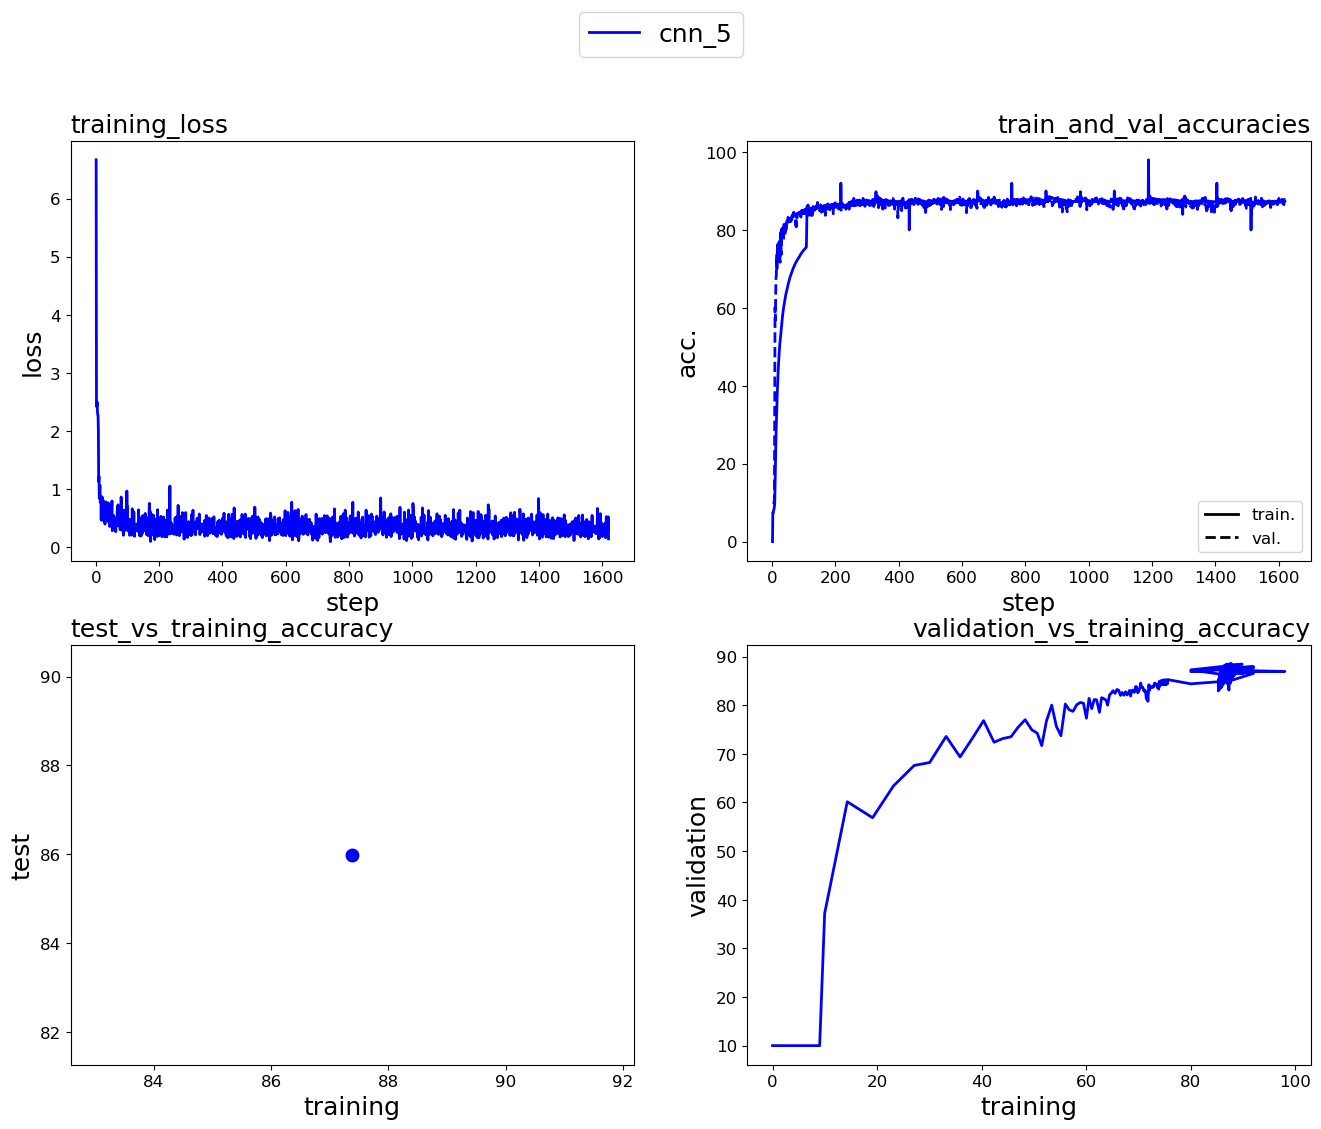

In [10]:
liste = [experiment_results]
ut.part3Plots(liste)

/Users/mustafaerdikararmaz/Documents/GitHub/Computational_Intelligence/HW1/Part3/utils.py:438: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


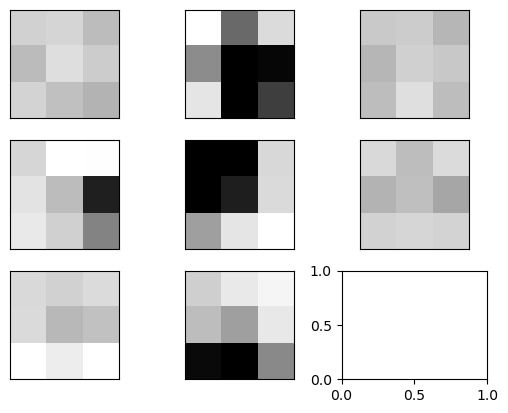

In [11]:
ut.visualizeWeights(first_layer_weights,'/Users/mustafaerdikararmaz/Documents/GitHub/Computational_Intelligence/HW1')